In [16]:
import numpy as np
import pandas as pd
import psycopg2
import sys
import os
import urllib
import sqlalchemy
from dotenv import load_dotenv
load_dotenv()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [17]:
alq_dbConnections = []
def alq_connectToDB(host, username, database, password):
    password = urllib.parse.quote_plus(password)
    db_url = f'postgresql://{username}:{password}@{host}:5432/{database}'
    engine = sqlalchemy.create_engine(db_url)
    try:
        conn =  engine.connect()
        if (~conn.closed):
            print(f"Conexión ALQMY existosa a la DB {database}")
            alq_dbConnections.append([conn, database])
            return conn
    except Exception as error:
        print(error)
        sys.exit(1)

In [18]:
def alq_closeAllConn():
    # print("dbConnections",dbConnections)
    for conn in alq_dbConnections:
        # print(f'Cerrando conexión con la DB {conn[1]}')
        conn[0].close()
        if (conn[0].closed):
            print(f'Conexión ALQMY cerrada con la DB {conn[1]}')
        else:
            print(f"Error cerrando la conexión ALQMY a la DB {conn[1]}")
    alq_dbConnections.clear()

In [19]:
def handleError(error):
    print(error)
    # psy_closeAllConn()
    alq_closeAllConn()
    sys.exit(1)

In [20]:
def getDf_columnInfo(df:pd.DataFrame):
    total_rows = len(df)
    print(f"Total de registros en el DataFrame: {total_rows}")
    for column in df.columns:
        print(f"------------------------ [{column}] ------------------------")
        current_col = df[column].astype(str)
        print(f"Max length value: {current_col.str.len().max()}")
        print(f"Valores nulos: {round((df[column].isna().sum()/total_rows)*100, 2)}%")

In [21]:
def createTable_inDB(database, tableName, df:pd.DataFrame, if_exists):
    try:
        conn = alq_connectToDB("127.0.0.1", "postgres", database, os.getenv("password"))
        df.to_sql(tableName, con=conn, if_exists=if_exists, index=False)
        alq_closeAllConn()
    except Exception as error:
        handleError(error)

In [22]:
def runQuery_getDf(query, database):
    try:
        conn = alq_connectToDB("127.0.0.1", "postgres", database, os.getenv("password"))
        sql = pd.read_sql_query(query, conn)
        df =  pd.DataFrame(sql)
        alq_closeAllConn()
    except Exception as error:
        handleError(error)
    return df

In [23]:
# Data Source: https://datacatalog.worldbank.org/search/dataset/0038132/Worldwide-Bureaucracy-Indicators
df_country_raw = pd.read_csv("WWBICountry.csv")
df_data_raw = pd.read_csv("WWBIData.csv")
df_indicator_raw = pd.read_csv("WWBISeries.csv")

In [24]:
df_country = df_country_raw[["Country Code", "Short Name", "Region"]].copy()
df_country.rename(columns={"Country Code":"country_code", "Short Name":"country_name", "Region":"country_region"}, inplace=True)


In [25]:
df_indicator_raw["Indicator Name"] = df_indicator_raw["Indicator Name"].str.lower()
df_indicator_raw[df_indicator_raw["Indicator Name"].str.contains("female")]
df_indicator = df_indicator_raw[["Series Code", "Indicator Name"]].copy()
df_indicator.rename(columns={"Series Code":"indicator_code", "Indicator Name":"indicator_name"}, inplace=True)

In [26]:
df_data = df_data_raw.copy()
if ("Unnamed: 25" in df_data.columns):
    df_data.drop(columns=["Unnamed: 25"], axis=1, inplace=True)
df_data = pd.melt(df_data, id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"], var_name="year", value_name="indicator_value")
df_data.drop(columns=["Country Name", "Indicator Name"], axis=1, inplace=True)
df_data.rename(columns={"Country Code":"country_code", "Indicator Name":"indicator_name", "Indicator Code":"indicator_code"}, inplace=True)

# ¿Cómo evoluciona el porcentaje de participación que tienen las mujeres en el sector público y privado para las diferentes ocupaciones en la región “Latinoamericana y el Caribe”?


Se parte el análisis identificando los indicadores disponibles sobre el empleo femenino

In [27]:
df_indicator[df_indicator["indicator_name"].str.contains("female")]

,indicator_code,indicator_name
13,BI.EMP.PUBS.FE.CK.ZS,"public sector female employment, as a share of paid employment by occupational group: clerks"
14,BI.EMP.PUBS.FE.ED.ZS,"public sector female employment, as a share of paid employment by industry: education"
15,BI.EMP.PUBS.FE.EO.ZS,"public sector female employment, as a share of paid employment by occupational group: elementary workers"
16,BI.EMP.PUBS.FE.HE.ZS,"public sector female employment, as a share of paid employment by industry: health"
17,BI.EMP.PUBS.FE.MW.ZS,"public sector female employment, as a share of paid employment by occupation: medical workers"
18,BI.EMP.PUBS.FE.PN.ZS,"public sector female employment, as a share of paid employment by occupational group: professionals"
19,BI.EMP.PUBS.FE.SN.ZS,"public sector female employment, as a share of paid employment by occupational group: manager"
20,BI.EMP.PUBS.FE.TN.ZS,"public sector female employment, as a share of paid employment by occupational group: technicians"
21,BI.EMP.PUBS.FE.TS.ZS,"public sector female employment, as a share of paid employment by occupation: teachers"
29,BI.EMP.PWRK.PB.FE.ZS,"public sector employment, as a share of paid employment by gender: female"


Se considera que los indicadores de interés son:
* females, as a share of private paid employees
* females, as a share of public paid employees

Tomando en cuenta que la data esta segmentada en sectores privado y público el análisis se realizará de igual manera por sector. 

Se obtiene la media de la participación de la mujeres en el empleo del sector privado por año para todos los paises de la región Latinoamerica y el Caribe. Con el fin de determinar de una forma gráfica si este ha evolucionado en el tiempo

In [28]:
df_indicator[df_indicator["indicator_name"] == "females, as a share of private paid employees"]["indicator_code"]

131    BI.PWK.PRVS.FE.ZS
Name: indicator_code, dtype: object

In [29]:
result = df_data[df_data["country_code"].isin(df_country[df_country["country_region"] == "Latin America & Caribbean"]["country_code"]) 
                 & (df_data["indicator_code"].isin(df_indicator[df_indicator["indicator_name"]
                                                                 == "females, as a share of private paid employees"]
                                                                 ["indicator_code"]))].groupby(by=["year"])["indicator_value"].mean().reset_index()
result["indicator_value"] = result["indicator_value"] * 100

Text(0, 0.5, 'Promedio del porcentaje de participación')

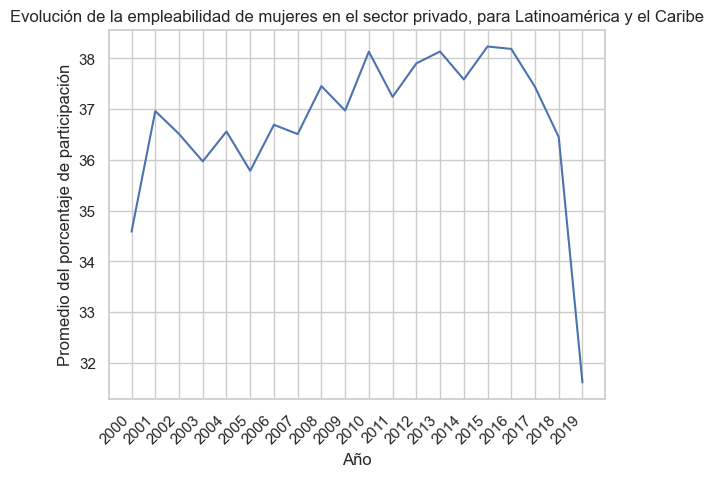

In [30]:
sns.lineplot(x="year", y="indicator_value", data=result)
plt.title("Evolución de la empleabilidad de mujeres en el sector privado, para Latinoamérica y el Caribe")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Año")
plt.ylabel("Promedio del porcentaje de participación")

In [31]:
result = df_data[df_data["country_code"].isin(df_country[df_country["country_region"] == "Latin America & Caribbean"]["country_code"]) 
                 & (df_data["indicator_code"].isin(df_indicator[df_indicator["indicator_name"]
                                                                 == "females, as a share of public paid employees"]
                                                                 ["indicator_code"]))].groupby(by=["year"])["indicator_value"].mean().reset_index()
result["indicator_value"] = result["indicator_value"] * 100

Text(0, 0.5, 'Promedio del porcentaje de participación')

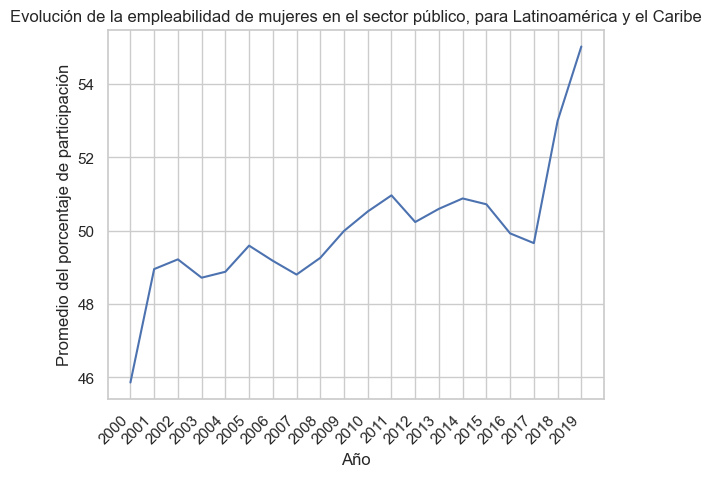

In [32]:
sns.lineplot(x="year", y="indicator_value", data=result)
plt.title("Evolución de la empleabilidad de mujeres en el sector público, para Latinoamérica y el Caribe")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Año")
plt.ylabel("Promedio del porcentaje de participación")